# First section: connect to drive and prepare the environment


In [1]:
#Connect file to /content/drive, actually you colab folder path is /content/drive/MyDrive/colab
from google.colab import drive
drive.mount('/content/drive')

#Change the current path to our work directory
import os
path = "/content/drive/MyDrive/ColabNotebooks/socialScienceProject"
os.chdir(path)
os.listdir

!nvidia-smi
!pip install ogb
!pip install torch
!pip install dgl==1.1.0 -f https://data.dgl.ai/wheels/repo.html

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    

In [2]:
from ogb.nodeproppred import DglNodePropPredDataset

mag_dataset = DglNodePropPredDataset(name = "ogbn-mag")
mag_split_idx = mag_dataset.get_idx_split()
mag_train_idx, mag_valid_idx, mag_test_idx = mag_split_idx["train"], mag_split_idx["valid"], mag_split_idx["test"]
mag_graph, mag_label = mag_dataset[0] # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [48]:
print(mag_graph)
print(mag_label)

Graph(num_nodes={'author': 1134649, 'field_of_study': 59965, 'institution': 8740, 'paper': 736389},
      num_edges={('author', 'affiliated_with', 'institution'): 1043998, ('author', 'writes', 'paper'): 7145660, ('paper', 'cites', 'paper'): 5416271, ('paper', 'has_topic', 'field_of_study'): 7505078},
      metagraph=[('author', 'institution', 'affiliated_with'), ('author', 'paper', 'writes'), ('paper', 'paper', 'cites'), ('paper', 'field_of_study', 'has_topic')])
{'paper': tensor([[246],
        [131],
        [189],
        ...,
        [266],
        [289],
        [  1]])}


In [3]:
from ogb.nodeproppred import DglNodePropPredDataset

arxiv_dataset = DglNodePropPredDataset(name = "ogbn-arxiv")
arxiv_split_idx = arxiv_dataset.get_idx_split()
arxiv_train_idx, arxiv_valid_idx, arxiv_test_idx = arxiv_split_idx["train"], arxiv_split_idx["valid"], arxiv_split_idx["test"]
arxiv_graph, arxiv_label = arxiv_dataset[0] # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)

# Second Section: we need to output the basic information of this 2 dataset, and sample a samller dataset from the mag with 2w nodes.

## 2.1 Here we generate basic information of 2 dataset

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random

# ------------------------- Utility Functions -------------------------
def plot_degree_distribution(degrees, title, filename, loglog=False):

    degree_counts = Counter(degrees)
    x, y = zip(*degree_counts.items())

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=20, alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel('Degree' if not loglog else 'Degree (log)')
    plt.ylabel('Frequency' if not loglog else 'Frequency (log)')

    if loglog:
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--")
    else:
        plt.grid(True)

    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def analyze_network(G, network_name):
    # ----------------- Basic Properties -----------------
    metrics = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_in_degree': np.mean([d for _, d in G.in_degree()]),
        'avg_out_degree': np.mean([d for _, d in G.out_degree()]),
        'density': nx.density(G)
    }

    # ----------------- Degree Distributions -----------------
    print(G.number_of_nodes())
    print(G.number_of_edges())

    all_degrees = list(dict(G.degree()).values())
    print(all_degrees)

    plot_degree_distribution(all_degrees,
                           f"{network_name} Degree Distribution (Linear)",
                           f"{network_name}_degree_linear")
    plot_degree_distribution(all_degrees,
                           f"{network_name} Degree Distribution (Log-Log)",
                           f"{network_name}_degree_log",
                           loglog=True)


    # ----------------- Giant Component Analysis -----------------
    if nx.is_directed(G):
        scc = max(nx.strongly_connected_components(G), key=len)
        #gain the giant component, with all the attributes of the original graph
        G_gc = G.subgraph(scc)
    else:
        gcc = max(nx.connected_components(G), key=len)
        G_gc = G.subgraph(gcc)

    metrics['gc_nodes'] = G_gc.number_of_nodes()
    print(G_gc.number_of_nodes())

    # ----------------- Path Length Distribution -----------------
    path_lengths = []

    sample_size = 50
    sampled_nodes = random.sample(list(G_gc.nodes()), sample_size)

    for node in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(G_gc, node)
        print
        path_lengths.extend(lengths.values())

    plt.figure(figsize=(10,6))
    plt.hist(path_lengths, bins=30)
    plt.title(f"{network_name} Path Length Distribution")
    plt.savefig(f"{network_name}_path_lengths.png", dpi=300)
    plt.show()
    plt.close()

    metrics['avg_path_length'] = np.mean(path_lengths)

    # ----------------- Clustering Analysis -----------------
    sampled_clustering = {}

    # Convert MultiDiGraph to DiGraph
    G_simple = nx.DiGraph(G_gc)
    for node in sampled_nodes:
        sampled_clustering[node] = nx.clustering(G_simple, node)
    clustering = sampled_clustering

    plt.figure(figsize=(10,6))
    plt.hist(clustering.values(), bins=30)
    plt.title(f"{network_name} Clustering Coefficients")
    plt.savefig(f"{network_name}_clustering.png", dpi=300)
    plt.show()
    plt.close()

    metrics['avg_clustering'] = np.mean(list(clustering.values()))

    return metrics


23164


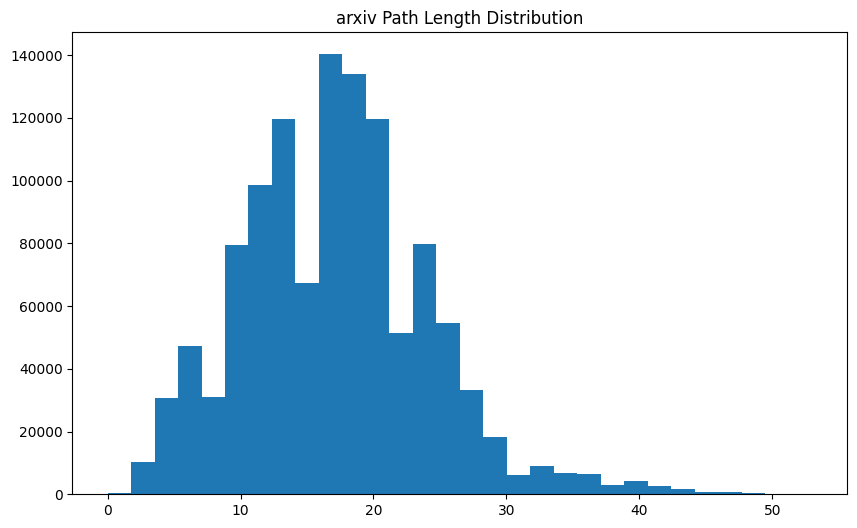

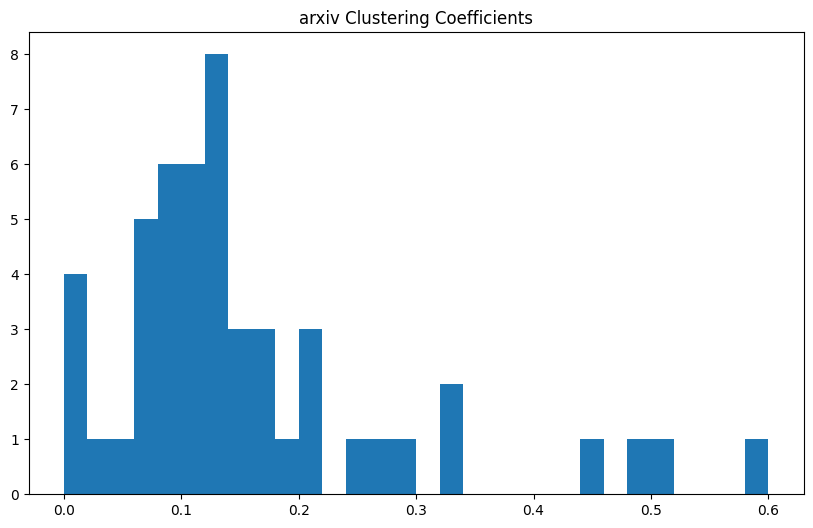

{'num_nodes': 169343, 'num_edges': 1166243, 'avg_in_degree': np.float64(6.886868663009395), 'avg_out_degree': np.float64(6.886868663009395), 'density': 4.066840277668502e-05, 'gc_nodes': 23164, 'avg_path_length': np.float64(17.13355724399931), 'avg_clustering': np.float64(0.1587980088051908)}


In [11]:
import dgl
arxiv_G = dgl.to_networkx(arxiv_graph, edge_attrs=None, node_attrs=None)
arxiv_metrics = analyze_network(arxiv_G, "arxiv")
print(arxiv_metrics)

736389
5416271
[7, 1, 4, 7, 2, 5, 9, 15, 4, 29, 6, 18, 3, 8, 1, 3, 4, 1, 7, 1, 1, 28, 7, 19, 7, 7, 1, 2, 24, 14, 13, 7, 16, 16, 1, 1, 4, 31, 1, 11, 4, 1, 1, 1, 21, 22, 10, 7, 16, 4, 2, 16, 49, 7, 15, 1, 9, 1, 14, 8, 2, 17, 7, 1, 12, 4, 2, 30, 35, 3, 11, 7, 17, 2, 24, 11, 13, 2, 9, 7, 4, 10, 10, 5, 13, 37, 3, 9, 7, 7, 6, 3, 3, 1, 9, 6, 19, 1, 2, 2, 6, 2, 8, 2, 1, 13, 3, 12, 5, 8, 3, 21, 21, 1, 9, 23, 3, 1, 2, 7, 4, 31, 8, 6, 3, 12, 26, 1, 34, 25, 4, 9, 2, 6, 51, 21, 39, 5, 46, 8, 9, 3, 2, 11, 92, 15, 5, 2, 9, 12, 34, 76, 6, 6, 2, 3, 11, 7, 1, 7, 5, 17, 42, 1, 8, 7, 18, 4, 3, 2, 16, 9, 47, 8, 9, 2, 3, 9, 2, 15, 3, 15, 7, 2, 21, 25, 30, 3, 9, 2, 19, 4, 24, 8, 2, 2, 5, 16, 5, 9, 3, 1, 4, 1, 32, 1, 1, 4, 6, 5, 19, 1, 1, 16, 18, 1, 29, 1, 5, 1, 4, 3, 7, 10, 13, 2, 1, 32, 11, 12, 11, 3, 9, 6, 103, 2, 5, 85, 2, 3, 16, 7, 31, 11, 2, 3, 13, 4, 22, 6, 4, 1, 29, 4, 1, 5, 17, 1, 25, 3, 4, 4, 5, 21, 5, 4, 5, 3, 3, 5, 14, 4, 22, 5, 2, 9, 15, 1, 5, 2, 2, 10, 3, 2, 1, 4, 16, 12, 6, 19, 3, 32, 5, 35, 14

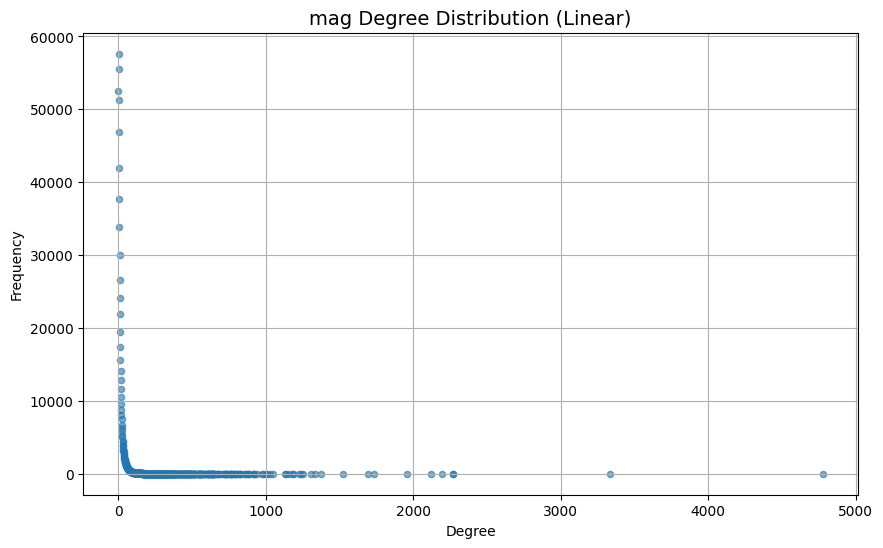

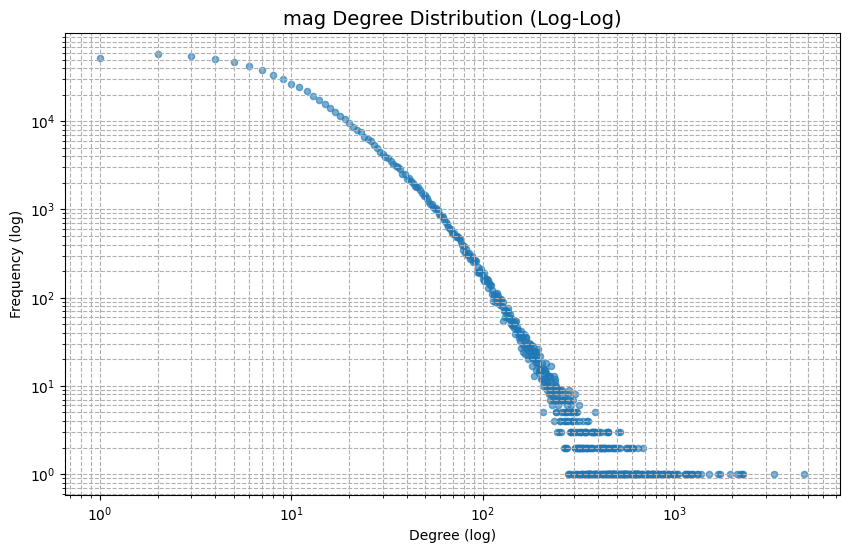

120104


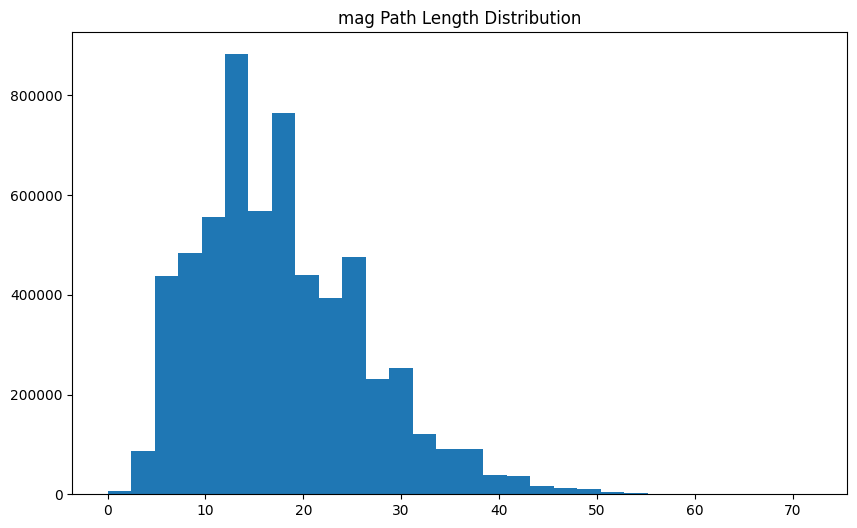

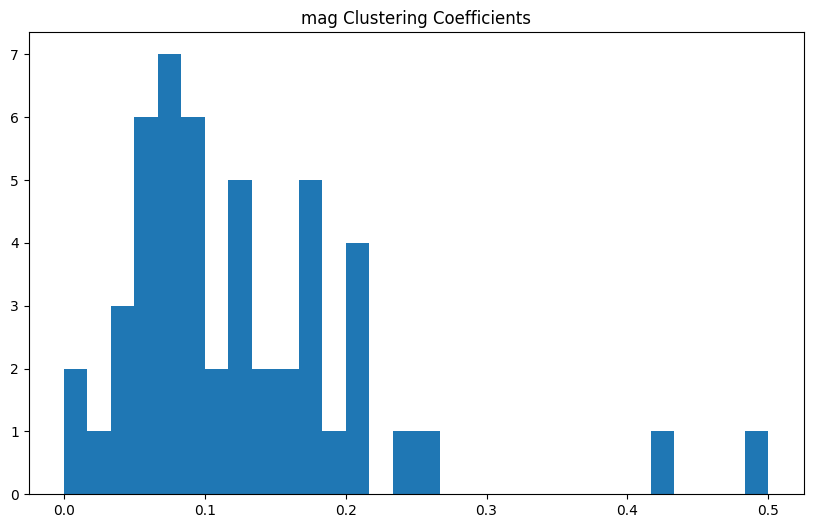

{'num_nodes': 736389, 'num_edges': 5416271, 'avg_in_degree': np.float64(7.355176408121251), 'avg_out_degree': np.float64(7.355176408121251), 'density': 9.988180698383531e-06, 'gc_nodes': 120104, 'avg_path_length': np.float64(17.743674981682542), 'avg_clustering': np.float64(0.1247242372605572)}


In [5]:
import dgl
paper_edges = ('paper', 'cites', 'paper')
paper_graph = mag_graph.edge_type_subgraph([paper_edges])
mag_G = dgl.to_homogeneous(paper_graph)
mag_G = dgl.to_networkx(mag_G, edge_attrs=None, node_attrs=None)
mag_metrics = analyze_network(mag_G, "mag")
print(mag_metrics)

## 2.2 Here we sample a subgraph of mag containing 2w nodes.

In [13]:
import dgl
import torch

def bfs_sampling_with_high_degree(dgl_graph, target_node_limit=20000):
    # 选择度数最高的节点作为种子节点
    all_degrees = dgl_graph.in_degrees()  # 获取节点的入度
    start_node = torch.argmax(all_degrees).item()  # 找到入度最高的节点

    # 广度优先搜索（BFS）扩展邻居节点
    visited_nodes = set()
    queue = [start_node]

    while queue and len(visited_nodes) < target_node_limit:
        node = queue.pop(0)
        if node not in visited_nodes:
            visited_nodes.add(node)
            queue.extend(dgl_graph.successors(node).tolist())  # 添加邻居节点

    # 将访问的节点创建为子图
    sampled_nodes = list(visited_nodes)
    subgraph = dgl.node_subgraph(dgl_graph, sampled_nodes)
    return subgraph

#仅保留节点和边，采用dgl对象的edge_type_subgraph的方法
paper_edges = ('paper', 'cites', 'paper')
paper_graph = mag_graph.edge_type_subgraph([paper_edges])

#从异构图转化为同质图，即节点和边都转化成统一类型，需要手动指定year和feat
mag_G = dgl.to_homogeneous(paper_graph, ndata=['year', 'feat'], edata=['reltype'])
# 示例：使用 BFS 基于高入度节点采样 2 万节点子图
sampled_graph = bfs_sampling_with_high_degree(mag_G, target_node_limit=20000)

print(mag_graph.ndata)
print(paper_graph.ndata)
print(sampled_graph.ndata)

#add mag_lables to sampled_graph
sampled_ids = sampled_graph.ndata['_ID']  # Original IDs of nodes in sampled_graph
#paper_labels = mag_label['paper'] #注意这里一定要添加paper才能通过_ID 访问标签
# Retrieve labels using original IDs
sampled_graph.ndata['y'] = mag_label['paper'][sampled_ids]  # Add labels to sampled graph

print(sampled_graph.ndata['y'].shape)

#save sampled graph
import pickle

def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)
    print(f"Graph saved to {filename}")

# Save your sampled graph
save_graph(sampled_graph, "sampled_graph_mag_20000.pkl")

defaultdict(<class 'dict'>, {'year': {'paper': tensor([[2015],
        [2012],
        [2012],
        ...,
        [2016],
        [2017],
        [2014]])}, 'feat': {'paper': tensor([[-0.0954,  0.0408, -0.2109,  ...,  0.0616, -0.0277, -0.1338],
        [-0.1510, -0.1073, -0.2220,  ...,  0.3458, -0.0277, -0.2185],
        [-0.1148, -0.1760, -0.2606,  ...,  0.1731, -0.1564, -0.2780],
        ...,
        [ 0.0228, -0.0865,  0.0981,  ..., -0.0547, -0.2077, -0.2305],
        [-0.2891, -0.2029, -0.1525,  ...,  0.1042,  0.2041, -0.3528],
        [-0.0890, -0.0348, -0.2642,  ...,  0.2601, -0.0875, -0.5171]])}})
{'year': tensor([[2015],
        [2012],
        [2012],
        ...,
        [2016],
        [2017],
        [2014]]), 'feat': tensor([[-0.0954,  0.0408, -0.2109,  ...,  0.0616, -0.0277, -0.1338],
        [-0.1510, -0.1073, -0.2220,  ...,  0.3458, -0.0277, -0.2185],
        [-0.1148, -0.1760, -0.2606,  ...,  0.1731, -0.1564, -0.2780],
        ...,
        [ 0.0228, -0.0865,  0.0981,

In [15]:
#load the saved sampled graph mag:
def load_graph(filename):
    with open(filename, 'rb') as f:
        graph = pickle.load(f)
    print(f"Graph loaded from {filename}")
    return graph

# Load the graph
loaded_graph = load_graph("sampled_graph_mag_20000.pkl")

# Verify the loaded graph structure
print("Node data:", loaded_graph.ndata.keys())
print("Edge data:", loaded_graph.edata.keys())


Graph loaded from sampled_graph_mag_20000.pkl
Node data: dict_keys(['year', 'feat', '_ID', '_TYPE', 'y'])
Edge data: dict_keys(['reltype', '_ID', '_TYPE'])


## 2.3 Then we describe the sampled subgraph of mag.

20000
177193
[1, 4, 24, 24, 12, 7, 8, 9, 14, 10, 4, 10, 26, 54, 31, 15, 9, 1, 26, 1, 13, 26, 6, 14, 2, 1, 1, 2, 13, 25, 2, 23, 9, 16, 18, 30, 14, 13, 29, 2, 17, 15, 1, 7, 20, 20, 7, 5, 38, 24, 52, 24, 2, 39, 7, 6, 16, 48, 21, 2, 7, 8, 8, 17, 7, 6, 10, 8, 10, 8, 6, 2, 15, 44, 2, 2, 16, 9, 23, 23, 41, 7, 8, 18, 3, 44, 11, 7, 6, 4, 16, 7, 21, 2, 33, 61, 11, 22, 18, 6, 6, 3, 18, 7, 85, 19, 33, 14, 24, 65, 46, 2, 8, 1, 5, 6, 6, 5, 11, 3, 11, 15, 15, 6, 17, 37, 7, 8, 7, 15, 6, 13, 6, 12, 26, 4, 82, 2, 4, 34, 23, 50, 3, 5, 3, 10, 18, 3, 3, 4, 5, 29, 9, 10, 36, 3, 21, 49, 10, 1, 21, 24, 43, 1, 2, 27, 7, 6, 8, 94, 15, 25, 8, 28, 2, 4, 9, 30, 4, 66, 24, 9, 5, 15, 19, 12, 7, 63, 25, 6, 19, 9, 31, 13, 44, 3, 1, 6, 17, 6, 14, 11, 1, 40, 14, 9, 10, 6, 6, 22, 10, 391, 15, 28, 9, 27, 25, 32, 31, 29, 5, 13, 28, 3, 3, 8, 3, 9, 34, 20, 30, 4, 18, 6, 7, 9, 18, 7, 1, 6, 14, 15, 20, 23, 7, 12, 9, 13, 55, 8, 10, 22, 13, 20, 8, 19, 6, 6, 4, 13, 4, 17, 12, 3, 22, 40, 14, 17, 17, 4, 95, 21, 2, 41, 3, 1, 9, 26, 

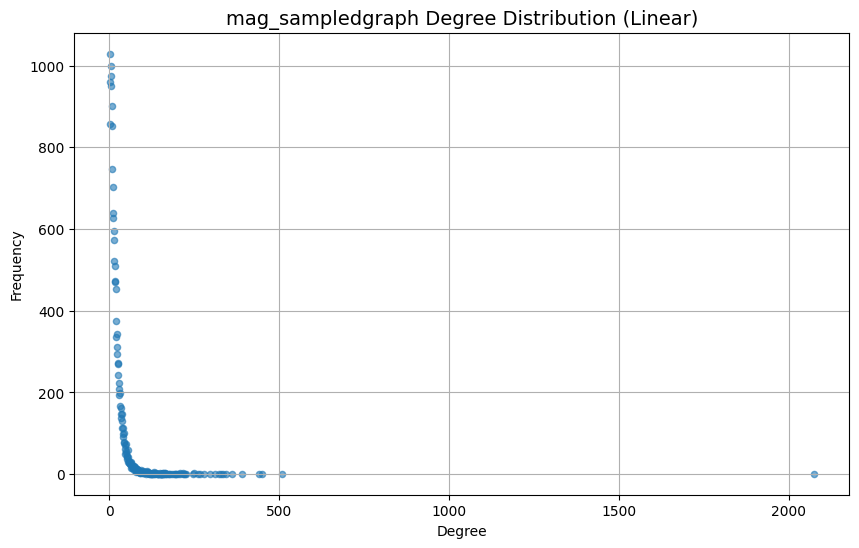

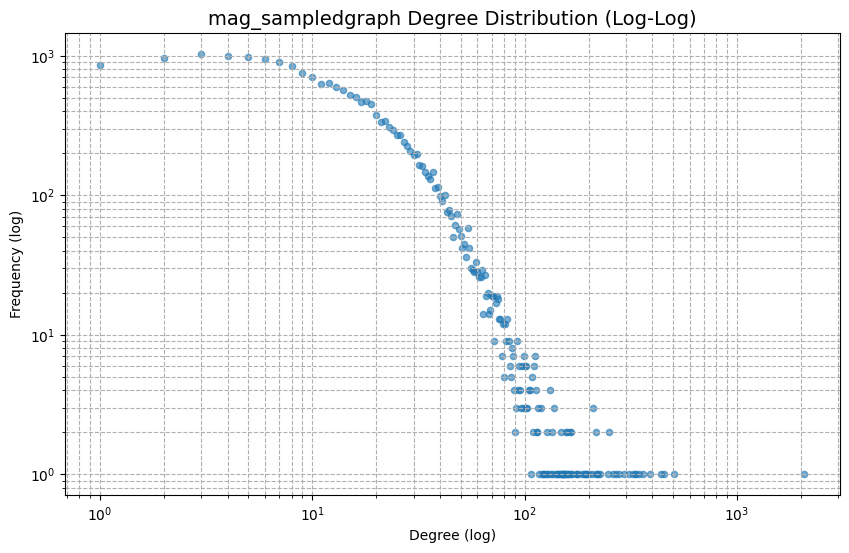

13440


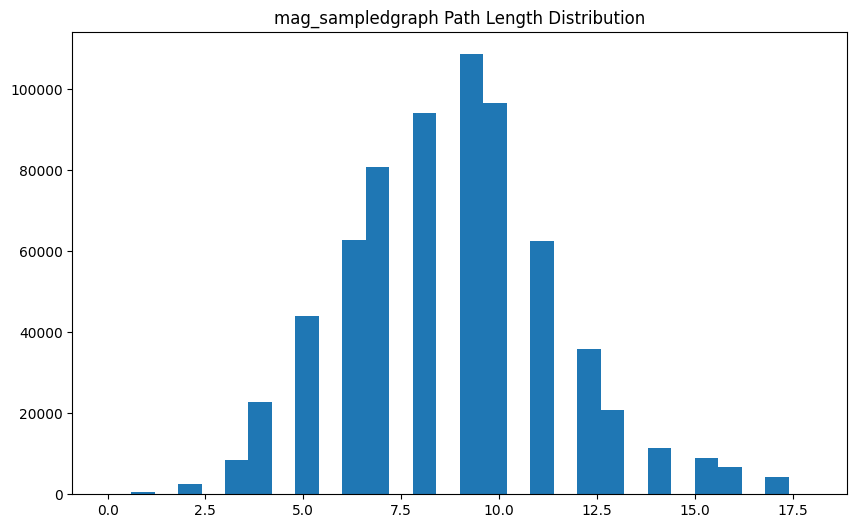

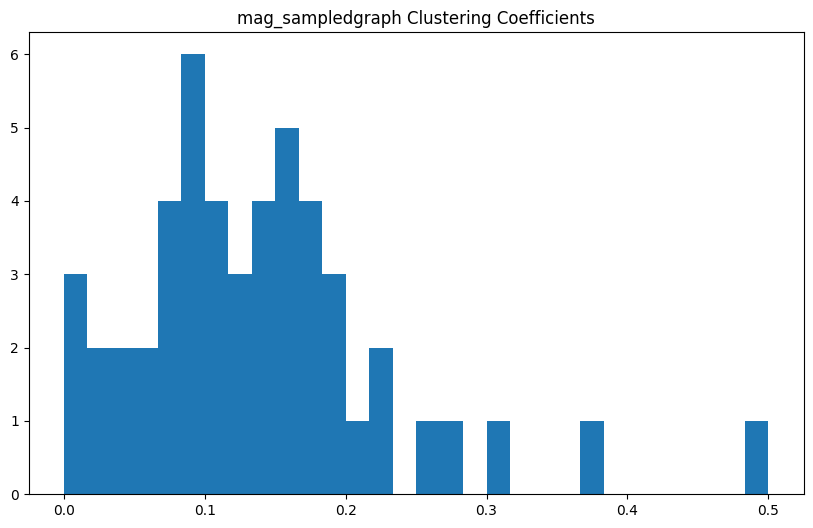

Number of nodes in sampled graph: 20000
Number of edges in sampled graph: 177193


In [28]:
#转换成network之后可以计算graph的特征并绘图
sampled_graph_nx = dgl.to_networkx(sampled_graph, edge_attrs=None, node_attrs=None)
mag_metrics = analyze_network(sampled_graph_nx, "mag_sampledgraph")

# 检查子图信息
print("Number of nodes in sampled graph:", sampled_graph.num_nodes())
print("Number of edges in sampled graph:", sampled_graph.num_edges())


In [29]:
print(mag_graph)
print(paper_graph)
print(sampled_graph)

Graph(num_nodes={'author': 1134649, 'field_of_study': 59965, 'institution': 8740, 'paper': 736389},
      num_edges={('author', 'affiliated_with', 'institution'): 1043998, ('author', 'writes', 'paper'): 7145660, ('paper', 'cites', 'paper'): 5416271, ('paper', 'has_topic', 'field_of_study'): 7505078},
      metagraph=[('author', 'institution', 'affiliated_with'), ('author', 'paper', 'writes'), ('paper', 'paper', 'cites'), ('paper', 'field_of_study', 'has_topic')])
Graph(num_nodes=736389, num_edges=5416271,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={'reltype': Scheme(shape=(1,), dtype=torch.int64)})
Graph(num_nodes=20000, num_edges=177193,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'reltype': Scheme(shape=(1,

Here we comes to train the sampled mag graph.

# Third Section:we can train the graphsage on sampled mag graph using the original embedding.

## 3.1 First we define the architecture of GraphSAGE

In [41]:
import torch
import torch.nn.functional as F
import dgl
from dgl.nn import SAGEConv
from sklearn.metrics import accuracy_score

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_layers, dropout):
        super(GraphSAGE, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, hidden_feats, aggregator_type='mean'))
        for _ in range(num_layers - 2):
            self.layers.append(SAGEConv(hidden_feats, hidden_feats, aggregator_type='mean'))
        self.layers.append(SAGEConv(hidden_feats, out_feats, aggregator_type='mean'))
        self.dropout = dropout

    def forward(self, g, x):
        for i, layer in enumerate(self.layers):
            x = layer(g, x)
            if i != len(self.layers) - 1:  # No activation on the last layer
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

# Training loop
def train(model, graph, features, labels, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(graph, features)
    loss = F.cross_entropy(out[train_idx], labels[train_idx], label_smoothing=0.1)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation loop
@torch.no_grad()
def evaluate(model, graph, features, labels, split_idx):
    model.eval()
    out = model(graph, features)
    preds = out.argmax(dim=1)
    train_acc = accuracy_score(labels[split_idx['train']].cpu(), preds[split_idx['train']].cpu())
    valid_acc = accuracy_score(labels[split_idx['valid']].cpu(), preds[split_idx['valid']].cpu())
    test_acc = accuracy_score(labels[split_idx['test']].cpu(), preds[split_idx['test']].cpu())
    return train_acc, valid_acc, test_acc

In [42]:
print(sampled_ids)
print(mag_train_idx['paper'])

tensor([393219, 262152, 524297,  ..., 131039, 131053, 131060])
tensor([     0,      1,      2,  ..., 736386, 736387, 736388])


## 3.2 Then we split the train dataset, validation dataset and test dataset

In [43]:
import torch

# 获取所有节点的年份信息
years = sampled_graph.ndata['year'].flatten()  # 将年份信息拉平为一维张量

# 使用 PyTorch 或 NumPy 统计年份分布
unique_years, year_counts = torch.unique(years, return_counts=True)

# 打印年份统计结果
print("Year Distribution:")
for year, count in zip(unique_years.tolist(), year_counts.tolist()):
    print(f"Year: {year}, Count: {count}")


# 按年份划分训练集、验证集和测试集
def split_by_year(graph, years, train_cutoff, valid_cutoff):
    # 创建布尔掩码
    train_mask = (years <= train_cutoff)  # 截止到 train_cutoff 年份属于训练集
    valid_mask = (years > train_cutoff) & (years <= valid_cutoff)  # 在 valid_cutoff 年份之间属于验证集
    test_mask = (years > valid_cutoff)  # 剩余的属于测试集

    # 将掩码添加到图中
    graph.ndata['train_mask'] = train_mask
    graph.ndata['valid_mask'] = valid_mask
    graph.ndata['test_mask'] = test_mask

    return graph

# 假设训练集为 2015 年及以前，验证集为 2016-2017 年，测试集为 2018 年及以后
train_cutoff_year = 2013
valid_cutoff_year = 2015

# 更新 sampled_graph 的掩码
sampled_graph = split_by_year(sampled_graph, years, train_cutoff_year, valid_cutoff_year)

# 验证划分结果
print("Number of training nodes:", sampled_graph.ndata['train_mask'].sum().item())
print("Number of validation nodes:", sampled_graph.ndata['valid_mask'].sum().item())
print("Number of testing nodes:", sampled_graph.ndata['test_mask'].sum().item())


Year Distribution:
Year: 2010, Count: 6791
Year: 2011, Count: 5366
Year: 2012, Count: 4042
Year: 2013, Count: 2258
Year: 2014, Count: 1072
Year: 2015, Count: 343
Year: 2016, Count: 94
Year: 2017, Count: 21
Year: 2018, Count: 10
Year: 2019, Count: 3
Number of training nodes: 18457
Number of validation nodes: 1415
Number of testing nodes: 128


## 3.3 Finally we start training

In [44]:
# Assume sampled_graph is your DGL graph with 20,000 nodes
#这里只需要change graph为arxiv，或者两者合并即可

# Create masks
#num_nodes = sampled_graph.num_nodes()
#train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Here we choose the node in the train idx as the train dataset
#train_mask[torch.isin(sampled_ids, mag_train_idx['paper'])] = True
#test_mask[torch.isin(sampled_ids, mag_test_idx['paper'])] = True

#sampled_graph.ndata['train_mask'] = train_mask
#sampled_graph.ndata['test_mask'] = test_mask


# Set up training parameters
features = sampled_graph.ndata['feat']

#notice the shape of the labels
labels = sampled_graph.ndata['y']
print(labels.shape)
labels = labels.squeeze(1)  # Convert shape from [20000, 1] to [20000]

# Extract masks
train_idx = torch.nonzero(sampled_graph.ndata['train_mask'], as_tuple=True)[0]
valid_idx = torch.nonzero(sampled_graph.ndata['valid_mask'], as_tuple=True)[0]
test_idx = torch.nonzero(sampled_graph.ndata['test_mask'], as_tuple=True)[0]
split_idx = {'train': train_idx, 'valid': valid_idx, 'test': test_idx}

in_feats = features.shape[1]
hidden_feats = 512
out_feats = labels.max().item() + 1
num_layers = 3
dropout = 0.3

model = GraphSAGE(in_feats, hidden_feats, out_feats, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Train indices shape:", train_idx.shape)

# Training loop
for epoch in range(100):  # Example: 100 epochs
    loss = train(model, sampled_graph, features, labels, train_idx, optimizer)
    train_acc, valid_acc, test_acc = evaluate(model, sampled_graph, features, labels, split_idx)
    print(f'Epoch {epoch + 1}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, '
              f'Valid Acc = {valid_acc:.4f}, Test Acc = {test_acc:.4f}')


torch.Size([20000, 1])
Features shape: torch.Size([20000, 128])
Labels shape: torch.Size([20000])
Train indices shape: torch.Size([18457])
Epoch 1: Loss = 6.2351, Train Acc = 0.2666, Valid Acc = 0.1753, Test Acc = 0.1016
Epoch 2: Loss = 6.9500, Train Acc = 0.1907, Valid Acc = 0.2643, Test Acc = 0.2969
Epoch 3: Loss = 5.2112, Train Acc = 0.1135, Valid Acc = 0.0650, Test Acc = 0.0156
Epoch 4: Loss = 4.4871, Train Acc = 0.1758, Valid Acc = 0.1223, Test Acc = 0.1641
Epoch 5: Loss = 4.5527, Train Acc = 0.1694, Valid Acc = 0.1223, Test Acc = 0.1953
Epoch 6: Loss = 4.6372, Train Acc = 0.1567, Valid Acc = 0.1124, Test Acc = 0.1953
Epoch 7: Loss = 4.5214, Train Acc = 0.1571, Valid Acc = 0.1060, Test Acc = 0.1953
Epoch 8: Loss = 4.2475, Train Acc = 0.1635, Valid Acc = 0.1131, Test Acc = 0.2031
Epoch 9: Loss = 3.9998, Train Acc = 0.1848, Valid Acc = 0.1272, Test Acc = 0.2031
Epoch 10: Loss = 3.9135, Train Acc = 0.1988, Valid Acc = 0.1350, Test Acc = 0.2344
Epoch 11: Loss = 3.6756, Train Acc = 0.2

In [ ]:
#python gnn.py --use_sage

import argparse

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels)) ## GraphSAGE卷积层（使用邻居采样聚合）
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)


def train(model, data, train_idx, optimizer, device):
    # 在训练循环开始前添加
    if device.type == 'xla':
        import torch_xla.core.xla_model as xm
        import torch_xla.distributed.parallel_loader as pl
        # 将模型和数据复制到TPU设备
        model = model.to(device)
        data = data.to(device)
        # 创建TPU优化器
        optimizer = xm.optim.Adam(model.parameters(), lr=args.lr)

    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx] #这个data.x 和data.adj_t是什么
    loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

import os
# 替换原有设备设置代码
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif 'COLAB_TPU_ADDR' in os.environ:  # 检测Colab TPU
        import torch_xla
        return torch.device('xla')
    else:
        return torch.device('cpu')


def main():
    parser = argparse.ArgumentParser(description='OGBN-Arxiv (GNN)')
    parser.add_argument('--device', type=int, default=0)
    parser.add_argument('--log_steps', type=int, default=1)
    parser.add_argument('--use_sage', type=bool, default=True) #默认使用GRAPHSAGE
    parser.add_argument('--num_layers', type=int, default=3)
    parser.add_argument('--hidden_channels', type=int, default=256)
    parser.add_argument('--dropout', type=float, default=0.5)
    parser.add_argument('--lr', type=float, default=0.01)
    parser.add_argument('--epochs', type=int, default=500)
    parser.add_argument('--runs', type=int, default=10)
    args,unknown = parser.parse_known_args()
    print(args)
    print(unknown)


    device = get_device()
    print(f"Using device: {device}")
    #device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'
    #print(device)
    #device = torch.device(device)

    dataset = PygNodePropPredDataset(name='ogbn-arxiv',
                                     transform=T.ToSparseTensor())

    data = dataset[0]
    data.adj_t = data.adj_t.to_symmetric()
    data = data.to(device)

    split_idx = dataset.get_idx_split()
    train_idx = split_idx['train'].to(device)

    if args.use_sage:
        model = SAGE(data.num_features, args.hidden_channels,
                     dataset.num_classes, args.num_layers,
                     args.dropout).to(device)
    else:
        model = GCN(data.num_features, args.hidden_channels,
                    dataset.num_classes, args.num_layers,
                    args.dropout).to(device)

    evaluator = Evaluator(name='ogbn-arxiv')
    #logger = Logger(args.runs, args)

    for run in range(args.runs):
        model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        for epoch in range(1, 1 + args.epochs):
            loss = train(model, data, train_idx, optimizer, device)
            result = test(model, data, split_idx, evaluator)
            #logger.add_result(run, result)

            if epoch % args.log_steps == 0:
                train_acc, valid_acc, test_acc = result
                print(f'Run: {run + 1:02d}, '
                      f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_acc:.2f}%, '
                      f'Valid: {100 * valid_acc:.2f}% '
                      f'Test: {100 * test_acc:.2f}%')

        #logger.print_statistics(run)
    #logger.print_statistics()


100000
1098063
[7, 4, 19, 11, 13, 55, 23, 16, 1, 27, 27, 7, 9, 32, 28, 26, 3, 26, 8, 14, 3, 5, 3, 2, 3, 11, 36, 4, 3, 19, 14, 51, 3, 30, 37, 7, 4, 30, 4, 4, 8, 26, 15, 14, 1, 19, 6, 8, 17, 24, 2, 42, 24, 6, 44, 1, 24, 3, 42, 9, 35, 1, 66, 26, 8, 24, 55, 46, 1, 34, 40, 9, 2, 6, 12, 21, 7, 8, 6, 9, 24, 9, 17, 60, 11, 1, 39, 12, 8, 17, 19, 1, 17, 4, 53, 88, 67, 4, 7, 15, 15, 19, 33, 3, 7, 2, 5, 1, 6, 7, 6, 4, 78, 11, 1, 34, 4, 1, 12, 15, 1, 21, 1, 119, 26, 34, 1, 7, 2, 6, 8, 30, 18, 3, 11, 3, 50, 11, 5, 20, 47, 62, 8, 14, 9, 35, 1, 3, 26, 29, 39, 4, 6, 1, 1, 5, 13, 1, 1, 10, 23, 7, 4, 22, 36, 10, 5, 35, 31, 4, 9, 1, 24, 32, 32, 12, 20, 3, 44, 3, 19, 4, 48, 38, 24, 11, 7, 1, 4, 58, 26, 60, 4, 24, 4, 11, 4, 14, 13, 13, 16, 5, 7, 8, 28, 1, 30, 1, 2, 5, 15, 8, 11, 16, 10, 18, 11, 1, 1, 1, 8, 6, 4, 107, 29, 18, 3, 16, 19, 36, 1, 40, 1, 42, 3, 1, 4, 106, 1, 3, 4, 25, 5, 9, 8, 18, 14, 2, 6, 48, 4, 2, 1, 9, 1, 4, 5, 12, 11, 1, 4, 30, 5, 2, 6, 2, 17, 3, 2, 34, 21, 14, 14, 23, 23, 9, 13, 64, 12, 29

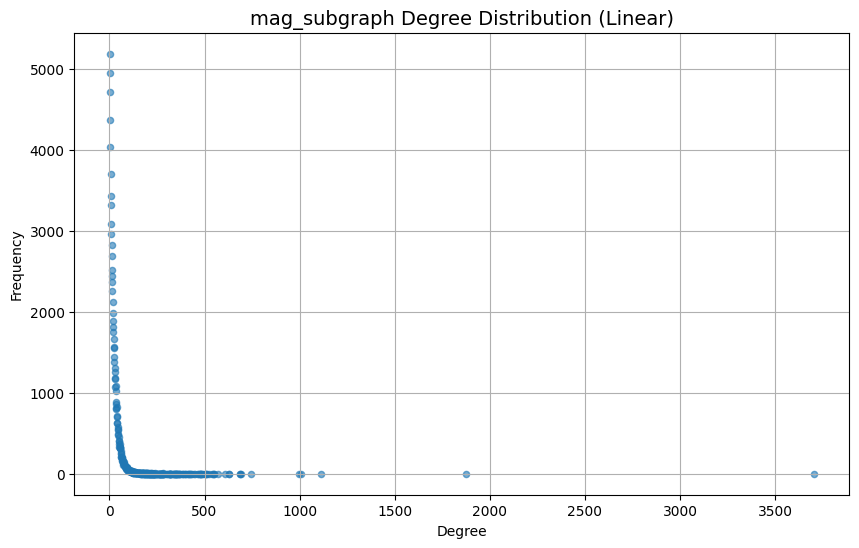

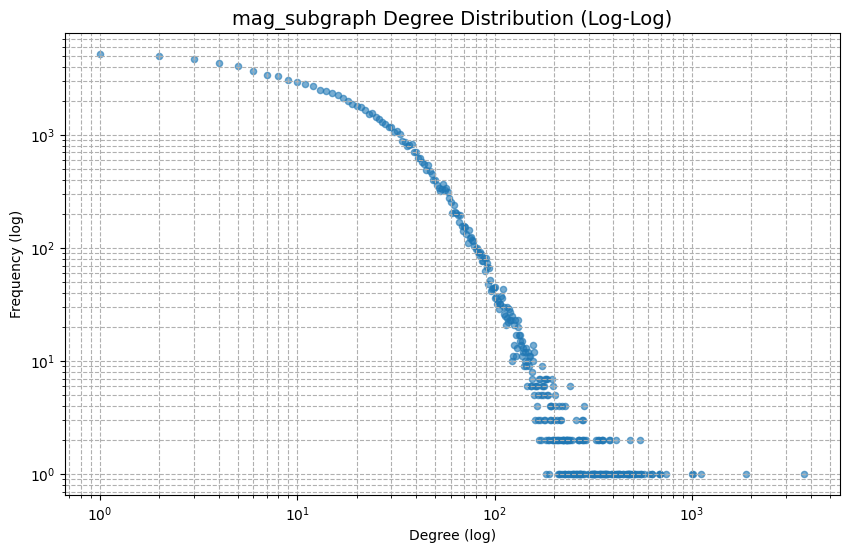

67153


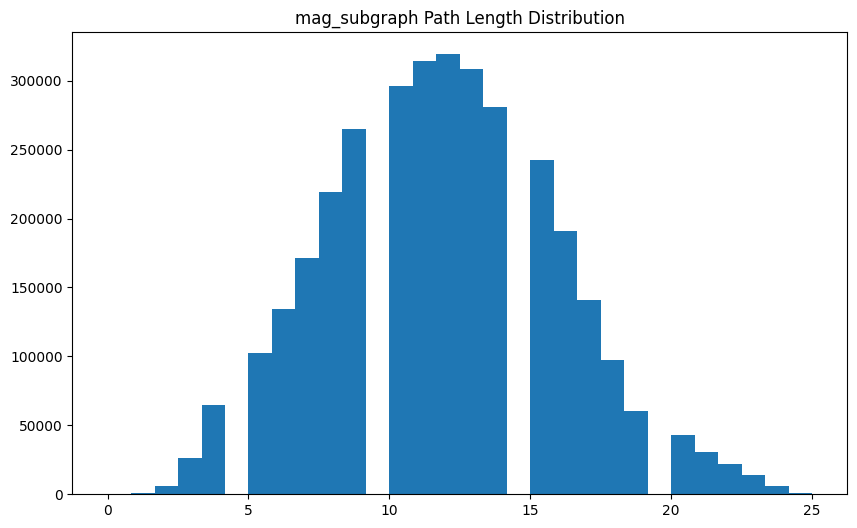

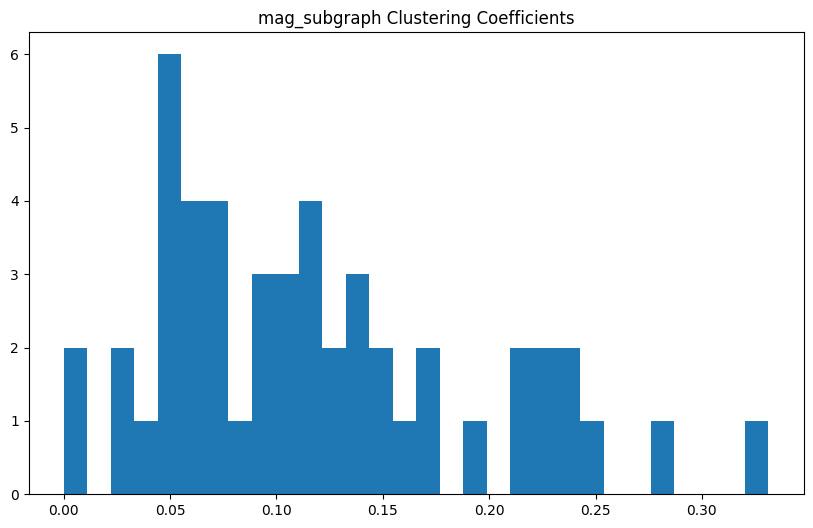

{'num_nodes': 100000, 'num_edges': 1098063, 'avg_in_degree': np.float64(10.98063), 'avg_out_degree': np.float64(10.98063), 'density': 0.00010980739807398073, 'gc_nodes': 67153, 'avg_path_length': np.float64(11.811792771730229), 'avg_clustering': np.float64(0.11881295273591638)}


In [16]:
#mag_G = dgl.to_networkx(sampled_subgraph, edge_attrs=None, node_attrs=None)

mag_metrics = analyze_network(sampled_subgraph, "mag_subgraph")
print(mag_metrics)

# Fourth Section:now we can train the graphsage using the 2 dataset together

In [ ]:
#现在要用e5编码我的paper了，如果我还是用标题和摘要呢？

# 加载你生成的 E5 编码（假设形状为 [num_papers, 384]）
paper_embeddings = np.load('paper_embeddings.npy')
paper_embeddings = torch.tensor(paper_embeddings, dtype=torch.float32)
graph.nodes['paper'].data['feat'] = paper_embeddings

# 为 author 节点生成随机初始特征（可替换为其他方法）??不要随机初始特征吧
graph.nodes['author'].data['feat'] = torch.randn(graph.num_nodes('author'), 128)
graph.nodes['institution'].data['feat'] = torch.randn(graph.num_nodes('institution'), 128)
graph.nodes['field_of_study'].data['feat'] = torch.randn(graph.num_nodes('field_of_study'), 128)

"""加入不使用随机初始化
# 方法1：作者特征 = 其撰写论文的 E5 特征均值
# ---------------------------------------------------
# 获取作者与论文的边关系（'author' -- 'writes' --> 'paper'）
author_paper_edges = graph.edges(etype=('author', 'writes', 'paper'))
author_ids, paper_ids = author_paper_edges[0], author_paper_edges[1]

# 计算每个作者的特征（聚合其所有论文的 E5 嵌入）
author_feat = torch.zeros(graph.num_nodes('author'), paper_embeddings.shape[1])
for author_id in torch.unique(author_ids):
    mask = author_ids == author_id
    author_feat[author_id] = paper_embeddings[paper_ids[mask]].mean(dim=0)

graph.nodes['author'].data['feat'] = author_feat

# 方法2：机构特征 = 其下属作者的特征均值
# ---------------------------------------------------
# 获取机构与作者的边关系（'author' -- 'affiliated_with' --> 'institution'）
author_inst_edges = graph.edges(etype=('author', 'affiliated_with', 'institution'))
author_ids, inst_ids = author_inst_edges[0], author_inst_edges[1]

# 计算每个机构的特征（聚合其所有作者的特征）
institution_feat = torch.zeros(graph.num_nodes('institution'), author_feat.shape[1])
for inst_id in torch.unique(inst_ids):
    mask = inst_ids == inst_id
    institution_feat[inst_id] = author_feat[author_ids[mask]].mean(dim=0)

graph.nodes['institution'].data['feat'] = institution_feat

# 方法3：研究领域特征 = 其相关论文的 E5 特征均值
# ---------------------------------------------------
# 获取论文与研究领域的边关系（'paper' -- 'has_topic' --> 'field_of_study'）
paper_field_edges = graph.edges(etype=('paper', 'has_topic', 'field_of_study'))
paper_ids, field_ids = paper_field_edges[0], paper_field_edges[1]

# 计算每个领域的特征（聚合其相关论文的 E5 嵌入）
field_feat = torch.zeros(graph.num_nodes('field_of_study'), paper_embeddings.shape[1])
for field_id in torch.unique(field_ids):
    mask = field_ids == field_id
    field_feat[field_id] = paper_embeddings[paper_ids[mask]].mean(dim=0)

graph.nodes['field_of_study'].data['feat'] = field_feat

"""


NameError: name 'np' is not defined

In [ ]:
import pandas as pd
paper_mapping = pd.read_csv("/content/dataset/ogbn_mag/mapping/paper_entidx2name.csv.gz", compression = "gzip")
print(paper_mapping) #这是nodeid到mag papaer id的映射

In [ ]:
import pandas as pd
author_mapping = pd.read_csv("/content/dataset/ogbn_mag/mapping/author_entidx2name.csv.gz", compression = "gzip")
print(author_mapping) #这是nodeid到author id的映射

In [ ]:
print(graph,label)

In [ ]:
#GraphSAGE是为同构图设计的，无法直接处理异构图的多类型节点和边
#分类型单独应用GraphSAGE，再聚合结果
#调整后的GraphSAGE模型
from dgl.nn import SAGEConv
import torch.nn as nn

class HeteroGraphSAGE(nn.Module):
    def __init__(self, in_feats_dict, hid_feats, out_feats):
        super().__init__()
        # 定义每个节点类型的投影层
        self.proj = nn.ModuleDict({
            ntype: nn.Linear(in_feats_dict[ntype], hid_feats)
            for ntype in in_feats_dict
        })
        # 定义异构卷积层（分边类型处理）
        self.conv1 = dgl.nn.HeteroGraphConv({
            rel: SAGEConv(hid_feats, hid_feats, 'mean')
            for rel in graph.etypes
        })
        self.classifier = nn.Linear(hid_feats, out_feats)

    def forward(self, graph):
        # 投影所有节点特征到 hid_feats
        h_dict = {ntype: self.proj[ntype](graph.nodes[ntype].data['feat'])
                  for ntype in graph.ntypes}
        # 异构卷积
        h_dict = self.conv1(graph, h_dict)
        h_dict = {k: nn.functional.relu(v) for k, v in h_dict.items()}
        # 分类（仅 paper 节点）
        return self.classifier(h_dict['paper'])

In [ ]:
#训练与苹

In [ ]:
#用不到，这是用来保存图的
import dgl
import torch
import pickle
from ogb.nodeproppred import DglNodePropPredDataset

# 加载数据
dataset = DglNodePropPredDataset(name="ogbn-arxiv")
split_idx = dataset.get_idx_split()
graph, labels = dataset[0]

# 方法1：保存为pickle
data_to_save = {"graph": graph, "labels": labels, "split_idx": split_idx}
with open("arxiv_data.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

# 方法2：使用DGL内置函数
dgl.save_graphs("arxiv_graph.dgl", [graph])
torch.save({"labels": labels, "split_idx": split_idx}, "arxiv_meta.pt")

print("数据保存成功！")

In [ ]:
!ls -lh

In [ ]:
#evaluator
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = "ogbg-mag")
# You can learn the input and output format specification of the evaluator as follows.
# print(evaluator.expected_input_format)
# print(evaluator.expected_output_format)
input_dict = {"y_true": y_true, "y_pred": y_pred}
result_dict = evaluator.eval(input_dict) # E.g., {"rocauc": 0.7321}

In [ ]:
#测试embedding，但是跑不起来
import argparse
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from ogb.nodeproppred import DglNodePropPredDataset
import wget
import shutil
import gzip


MODEL_NAME = {"e5": "intfloat/e5-small-v2", "ofa": "../../cache/transformer-model/multi-qa-distilbert-cos-v1"}
short_name = {"ogbn-papers100M": "100M", "ogbn-arxiv": "arxiv", "ogbn-products": "products"}


def decompress_gz(file_path, output_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed file to {output_path}")


class Ogb_dataset(Dataset):
    def __init__(self, datas):
        self.data = datas
        self.length = len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.length


class Tokenizer(object):
    def __init__(self, tokenizer, args):
        super(Tokenizer, self).__init__()
        self.max_token_len = args.max_token_len
        self.tokenizer = tokenizer
        self.padding = "max_length"
        self.truncation = True

    def __call__(self, examples):
        if isinstance(examples, str):
            return self.tokenizer(examples, padding=self.padding, truncation=self.truncation,
                                  max_length=self.max_token_len, return_tensors="pt")
        else:
            return self.tokenizer(examples["text"], padding=self.padding, truncation=self.truncation,
                                  max_length=self.max_token_len, return_tensors="pt")


class Gen_ogb_data():
    def __init__(self, args):
        self.args = args
        self.download_raw_data(args.dataset_name)
        self.get_text_data(args.dataset_name)
        self.get_emb(args.dataset_name)

    def average_pool(self, last_hidden_states, attention_mask):
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def download_raw_data(self, dataset_name="ogbn-arxiv"):
        os.makedirs(self.args.data_save_path, exist_ok=True)
        dataset_path = os.path.join(self.args.data_save_path, dataset_name)
        os.makedirs(dataset_path, exist_ok=True)
        if dataset_name == "ogbn-arxiv":
            if not os.path.exists(os.path.join(dataset_path, "titleabs.tsv")):
                url = "https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/titleabs.tsv.gz"
                wget.download(url, os.path.join(dataset_path, "titleabs.tsv.gz"))
                decompress_gz(os.path.join(dataset_path, "titleabs.tsv.gz"), os.path.join(dataset_path, "titleabs.tsv"))
                os.remove(os.path.join(dataset_path, "titleabs.tsv.gz"))
            self.dgl_dataset = DglNodePropPredDataset(dataset_name, root=os.path.join(self.args.data_save_path,
                                                                                      "ogb-official-data"))

    def get_text_data(self, dataset_name="ogbn-arxiv"):
        dataset_path = os.path.join(self.args.data_save_path, dataset_name)
        ogbn_official_path = os.path.join(self.args.data_save_path, "ogb-official-data")

        if dataset_name == "ogbn-arxiv":
            self.df = pd.read_csv(os.path.join(dataset_path, 'titleabs.tsv'), sep='\t')
            decompress_gz(os.path.join(ogbn_official_path, "ogbn_arxiv", "mapping", 'nodeidx2paperid.csv.gz'),
                          os.path.join(ogbn_official_path, "ogbn_arxiv", "mapping", 'nodeidx2paperid.csv'))
            self.nodeid2contentid = pd.read_csv(
                os.path.join(ogbn_official_path, "ogbn_arxiv", "mapping", 'nodeidx2paperid.csv'))
            self.df.columns = ["paperid", "title", "abs"]
            self.nodeid2contentid.columns = ["nodeid", "paperid"]
            data = pd.merge(self.nodeid2contentid, self.df, how="left", on="paperid")
            Datasets = data.values[:, 2:]

        dataframe = pd.DataFrame(Datasets)
        dataframe.to_csv(os.path.join(dataset_path, f'{dataset_name}_title_content.csv'), index=False)
        print(f"{dataset_name} title_content.csv has been saved!")

    def get_emb(self, dataset_name="ogbn-arxiv"):
        dataset_path = os.path.join(self.args.data_save_path, dataset_name)
        if dataset_name == "ogbn-arxiv":
            Datas = []
            data = pd.read_csv(os.path.join(dataset_path, f'{dataset_name}_title_content.csv')).values
            for k in range(data.shape[0]):
                data_dict = {}
                if pd.isnull(data[k][0]) and pd.isnull(data[k][1]):
                    data_dict["text"] = " .  "
                elif pd.isnull(data[k][1]):
                    data_dict["text"] = data[k][0]
                elif pd.isnull(data[k][0]):
                    data_dict["text"] = data[k][1]
                else:
                    data_dict["text"] = data[k][0] + ". " + data[k][1]
                Datas.append(data_dict)
            text_dataset = Ogb_dataset(Datas)
            text_dataloader = DataLoader(text_dataset, shuffle=False, batch_size=self.args.batch_size)
        else:
            raise ValueError

        if self.args.Model == "e5":
            tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[self.args.Model])
            model_tokenizer = Tokenizer(tokenizer, self.args)
            model = AutoModel.from_pretrained(MODEL_NAME[self.args.Model])
            model.to(self.args.device)
            model.eval()
            nodes_embed = []
            epoch_iter = tqdm(text_dataloader)
            print(f"Generating {self.args.Model} embedding!")
            with torch.no_grad():
                for batch in epoch_iter:
                    batch = model_tokenizer(batch)
                    batch = {k: v.to(self.args.device) for k, v in batch.items()}
                    outputs = model(**batch)
                    embeddings = self.average_pool(outputs.last_hidden_state, batch['attention_mask'])
                    for i in range(embeddings.shape[0]):
                        nodes_embed.append(embeddings[i].cpu().numpy().astype(self.args.dtype)) #我们这没有这么复杂

            nodes_embed = np.stack(nodes_embed, axis=0)
            np.save(os.path.join(dataset_path, f"{short_name[dataset_name]}_embedding_{self.args.Model}_{self.args.dtype}.npy"),
                    nodes_embed)
            print(f"{short_name[dataset_name]}_embedding_{self.args.Model}_{self.args.dtype}.npy has been saved!")

        elif self.args.Model == "ofa":
            model = SentenceTransformer(MODEL_NAME[self.args.Model])
            model.to(self.args.device)
            model.eval()
            with torch.no_grad():
                texts = []
                for d in Datas:
                    texts.append(d["text"])
                embeddings = model.encode(texts, batch_size=self.args.batch_size, show_progress_bar=True,
                                          convert_to_tensor=False, convert_to_numpy=True)
                np.save(os.path.join(dataset_path, f"{short_name[dataset_name]}_embedding_{self.args.Model}_{self.args.dtype}.npy"),
                        embeddings.astype(self.args.dtype))
            print(f"{short_name[dataset_name]}_embedding_{self.args.Model}_{self.args.dtype}.npy has been saved!")
        else:
            raise ValueError


if __name__ == "__main__":
    # 加载数据集
    dataset = DglNodePropPredDataset(name="ogbn-arxiv")
    split_idx = dataset.get_idx_split()
    train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
    graph, label = dataset[0]

    # 设置参数
    parser = argparse.ArgumentParser(description="")
    parser.add_argument('--data_save_path', type=str, default='./data')
    parser.add_argument('--device', type=str, default='cuda:0')
    parser.add_argument('--Model', type=str, default='e5')
    parser.add_argument('--batch_size', type=int, default=512)
    parser.add_argument('--dataset_name', type=str, default="ogbn-arxiv")
    parser.add_argument('--max_token_len', type=int, default=512)
    parser.add_argument('--dtype', type=str, default="float16")
    args = parser.parse_args()

    # 生成嵌入
    gen_ogb = Gen_ogb_data(args)


In [ ]:
!pip install wget

In [ ]:
#一种很新的训练方法
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
from dgl.data import AmazonCoBuyComputerDataset
from dgl.nn import SAGEConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import os

# Set the DGL backend to PyTorch
os.environ['DGLBACKEND'] = 'pytorch'


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
labels = g.ndata['label']

# Split the dataset into training/validation/testing sets
n_nodes = g.num_nodes()
indices = np.random.permutation(n_nodes)
train_idx = indices[:int(0.8*n_nodes)]  # 80% for training
val_idx = indices[int(0.8*n_nodes):int(0.9*n_nodes)]  # 10% for validation
test_idx = indices[int(0.9*n_nodes):]  # 10% for testing

# Create training/validation/testing masks
g.ndata['train_mask'] = torch.zeros(n_nodes, dtype=torch.bool)
g.ndata['val_mask'] = torch.zeros(n_nodes, dtype=torch.bool)
g.ndata['test_mask'] = torch.zeros(n_nodes, dtype=torch.bool)
g.ndata['train_mask'][train_idx] = True
g.ndata['val_mask'][val_idx] = True
g.ndata['test_mask'][test_idx] = True

# Define the GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, hid_feats, 'mean')  # First GraphSAGE layer
        self.conv2 = SAGEConv(hid_feats, hid_feats, 'mean')  # Second GraphSAGE layer
        self.classifier = nn.Linear(hid_feats, out_feats)  # Classification layer

    def forward(self, graph, x):
        x = F.relu(self.conv1(graph, x))  # Apply ReLU activation after the first layer
        x = F.relu(self.conv2(graph, x))  # Apply ReLU activation after the second layer
        return self.classifier(x)  # Output layer

# Prepare three types of node features
def prepare_features(g):
    # Feature type (i): All-one vectors
    ones_feat = torch.ones(g.ndata['feat'].shape)

    # Feature type (ii): Original node features
    original_feat = g.ndata['feat']

    # Feature type (iii): Structural features + one-hot encoding
    # Convert to a NetworkX graph
    # nx_g = g.to_networkx().to_undirected() This line would throw an error for multigraphs
    nx_g = nx.Graph(dgl.to_networkx(g.cpu()).to_undirected())
    # Note: nx.Graph function will merge multiple edges between nodes into a single edge,
    # as NetworkX does not support multigraph structures.
    print(nx_g.number_of_edges())  # Should output the original number of undirected edges: 245,778

    # Calculate structural features
    print("Calculating clustering coefficients...")
    clustering = nx.clustering(nx_g)
    print("Calculating degree centrality...")
    degree_cent = nx.degree_centrality(nx_g)
    print("Calculating betweenness centrality...")
    betweenness = nx.betweenness_centrality(nx_g, k=100)  # Sample some nodes to speed up calculation
    print("Calculating eigenvector centrality...")
    eigenvector = nx.eigenvector_centrality(nx_g, max_iter=1000)

    # Collect features and normalize them
    structural = np.array([[clustering[i], degree_cent[i],
                          betweenness[i], eigenvector[i]] for i in range(n_nodes)])
    structural = StandardScaler().fit_transform(structural)

    # Generate one-hot encodings
    one_hot = torch.eye(n_nodes)

    # Concatenate features
    structural_feat = torch.cat([torch.FloatTensor(structural), one_hot], dim=1)

    return {
        'ones': ones_feat,
        'original': original_feat,
        'structural+onehot': structural_feat
    }

features = prepare_features(g)

# Define the training function
def train_model(feature, label, train_mask, val_mask, test_mask, epochs=400):
    model = GraphSAGE(feature.shape[1], 64, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with learning rate 0.01
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss function

    best_val_acc = 0
    best_model = None
    history = {'loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        logits = model(g, feature)
        loss = criterion(logits[train_mask], label[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            pred = logits.argmax(1)
            val_acc = accuracy_score(label[val_mask].numpy(), pred[val_mask].numpy())

        history['loss'].append(loss.item())
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()

        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}')

    # Test the best model
    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        logits = model(g, feature)
        test_acc = accuracy_score(label[test_mask].numpy(),
                                 logits[test_mask].argmax(1).numpy())

    return history, test_acc

# Train and compare three types of features
results = {}
for feat_name in ['ones', 'original', 'structural+onehot']:
    print(f"\n=== Training with {feat_name} features ===")
    feat = features[feat_name]
    history, test_acc = train_model(feat, labels,
                                  g.ndata['train_mask'],
                                  g.ndata['val_mask'],
                                  g.ndata['test_mask'])
    results[feat_name] = {
        'train_loss': history['loss'],
        'val_acc': history['val_acc'],
        'test_acc': test_acc
    }

# Visualize the training process
plt.figure(figsize=(12, 4))
for i, feat in enumerate(results.keys()):
    plt.subplot(1, 2, 1)
    plt.plot(results[feat]['train_loss'], label=f'{feat}')
    plt.subplot(1, 2, 2)
    plt.plot(results[feat]['val_acc'], label=f'{feat}')

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

# Output the test results
print("\n=== Final Test Results ===")
for feat in results:
    print(f"{feat.ljust(20)} Test Accuracy: {results[feat]['test_acc']:.4f}")

In [ ]:
#不知道在干什么
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# 加载数据集
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/")
data = dataset[0]
split_idx = dataset.get_idx_split()

# 数据集划分
train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

# 定义GraphSAGE模型
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(data.num_features, 256, dataset.num_classes).to(device)
data = data.to(device)

# 优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 训练函数
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

# 验证函数
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask].squeeze()
        acc = int(correct.sum()) / int(mask.sum())
    return acc

# 训练过程
train_losses = []
val_accuracies = []
test_accuracy = 0
for epoch in range(100):  # 训练100轮
    loss = train()
    train_losses.append(loss)
    val_acc = evaluate(valid_idx)
    val_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}")

test_accuracy = evaluate(test_idx)

# 输出测试结果
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# 可视化训练损失和验证精度
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


1.打印两个数据集的基本信息
2.在arxiv数据集上训练GSEDG模型
3.在arxiv数据集上训练GSEDG模型

什么是GSEDG模型
是一个神经网络
Specifically, for ogbn-arxiv and ogbn-papers100M, we
generate embeddings using the titles and abstracts corresponding to the nodes. For ogbn-products,
we generate embeddings using the names and descriptions of the products associated with the nodes.

In [ ]:
from google.colab import drive

# 挂载Google Drive
drive.mount('/content/gdrive')


In [ ]:
# 创建一个名为 example.txt 的空文件
with open("/content/gdrive/My Drive/example.txt", "w") as file:
    pass


In [ ]:
!cd "/content/gdrive/My Drive/"


In [ ]:
!